## Dynamic

In [1]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks import *

In [2]:
cwd = os.getcwd()
path = cwd
#path

In [3]:
path_lbl = '../data/landuse_Level1_bw'
path_img = '../data/sentinel2'

In [4]:
fnames = get_image_files(path_img)
#fnames[:5]

In [5]:
label_names = get_image_files(path_lbl)
#label_names[:5]

In [6]:
codes = np.loadtxt('../data/codes_Level1.txt', dtype=str,delimiter=',')# ; codes

In [7]:
codes

array(['Tehisalad', 'Põllumajanduslikud alad', 'Metsad ja pool- looduslikud alad', 'Märgalad', 'Vesi'], dtype='<U32')

In [8]:
get_y_fn = lambda x: path_lbl+f'/{x.stem}{x.suffix}'

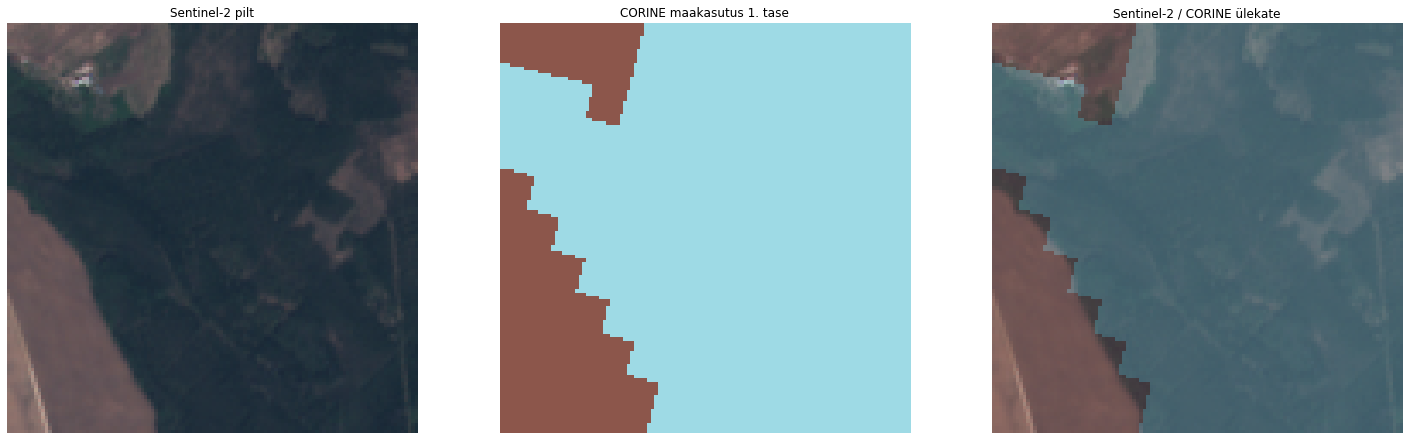

In [9]:
imgfn = fnames[0]
img = open_image(imgfn)
mask = open_mask(get_y_fn(imgfn))

_,axes = plt.subplots(1,3, figsize=(25,15))

img.show(ax=axes[0], title='Sentinel-2 pilt')
mask.show(ax=axes[1], alpha=1, title='CORINE maakasutus 1. tase')
img.show(ax=axes[2], y=mask, alpha=0.3, title='Sentinel-2 / CORINE ülekate')

In [10]:
size = np.array(mask.shape[1:])
bs = 16

In [11]:
src = (SegmentationItemList.from_folder(path_img)  # Load in x data from folder
       .split_by_rand_pct(seed=42)  # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)  # Label data using the get_y_fn function
      )

data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)  # Flip images horizontally and vertically
        .databunch(bs=bs)  # Create a databunch
        .normalize(imagenet_stats)  # Normalize for resnet
       )

In [12]:
def accuracy_seg(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [13]:
learn = unet_learner(data, models.resnet50, metrics=[accuracy_seg],callback_fns=[ShowGraph])

In [14]:
encoder_path = path+'/models/Level1_stage-2-rn50.h5'

In [15]:
learn.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


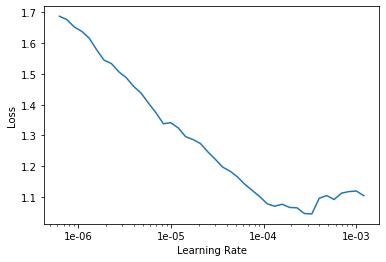

In [16]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_seg,time
0,0.366356,0.270806,0.900062,04:23
1,0.336381,0.264606,0.903252,04:09
2,0.288692,0.253279,0.906489,04:08
3,0.255578,0.222614,0.913219,04:08
4,0.238009,0.222202,0.913218,04:08


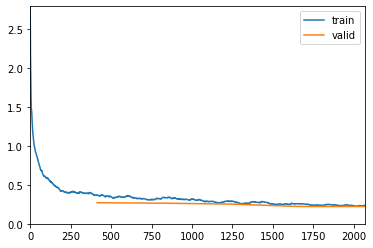

In [16]:
#Try lr 1e-4
lr=1e-4
learn.fit_one_cycle(5, slice(lr))

In [17]:
learn.save('Level1-unet-stage-1')

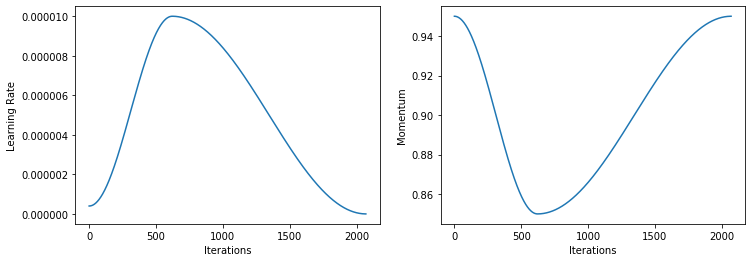

In [20]:
learn.recorder.plot_lr(show_moms=True)

In [18]:
learn.load('Level1-unet-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (6625 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Valid: LabelList (1656 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
     

In [18]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_seg,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


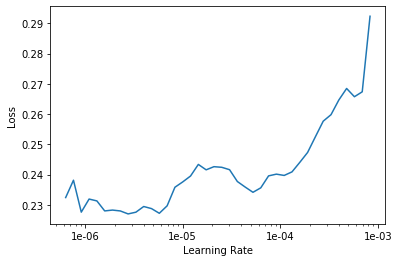

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr=6e-6

epoch,train_loss,valid_loss,accuracy_seg,time
0,0.231638,0.221958,0.912958,04:15
1,0.236955,0.221985,0.913960,04:15
2,0.236416,0.218285,0.914557,04:15
3,0.222609,0.222335,0.913521,04:15
4,0.220366,0.215618,0.914649,04:15


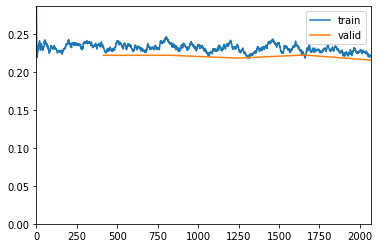

In [21]:
learn.fit_one_cycle(5, slice(lr))

In [22]:
learn.save('Level1-unet-stage-2')

In [14]:
learn.load('Level1-unet-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (6625 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Valid: LabelList (1656 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
     

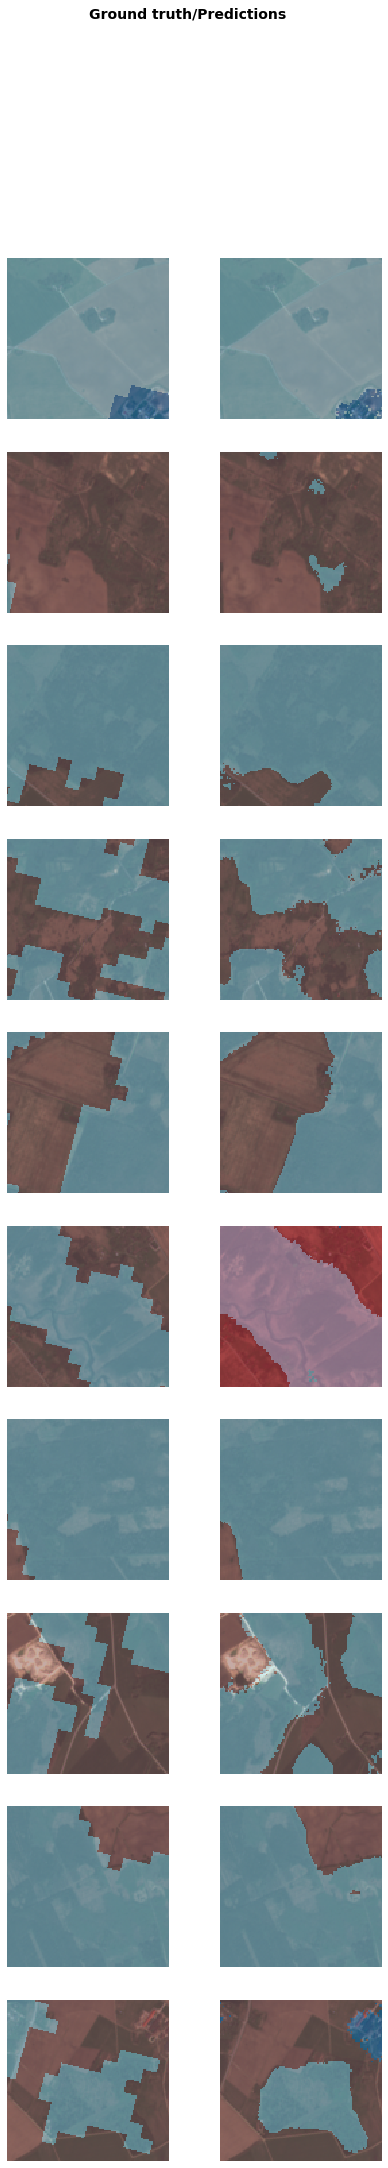

In [23]:
learn.show_results(rows=10, figsize=(7,35))

In [15]:
#filenames = data.valid_dl.items

In [16]:
#preds = learn.get_preds()

In [17]:
#len(preds[0]), len(preds[1])

(1656, 1656)

In [29]:
#learn.validate()

[0.23111235, tensor(0.9089), tensor(1.8093)]

In [18]:
#valid_df = pd.DataFrame(list(zip(filenames, preds[0].squeeze().tolist(), preds[1].squeeze().tolist())))

In [19]:
#valid_df.head()

,0,1,2
0,../data/sentinel2/landusage_est_22_56.png,"[[[0.07959172874689102, 0.054019343107938766, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,../data/sentinel2/landusage_est_88_89.png,"[[[0.07128092646598816, 0.044906605035066605, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,../data/sentinel2/landusage_est_48_32.png,"[[[0.017483869567513466, 0.010235900059342384,...","[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
3,../data/sentinel2/landusage_est_09_13.png,"[[[0.04416166990995407, 0.028608618304133415, ...","[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
4,../data/sentinel2/landusage_est_18_17.png,"[[[0.017535880208015442, 0.011218775995075703,...","[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."


In [20]:
#filenames[0]

PosixPath('../data/sentinel2/landusage_est_22_56.png')

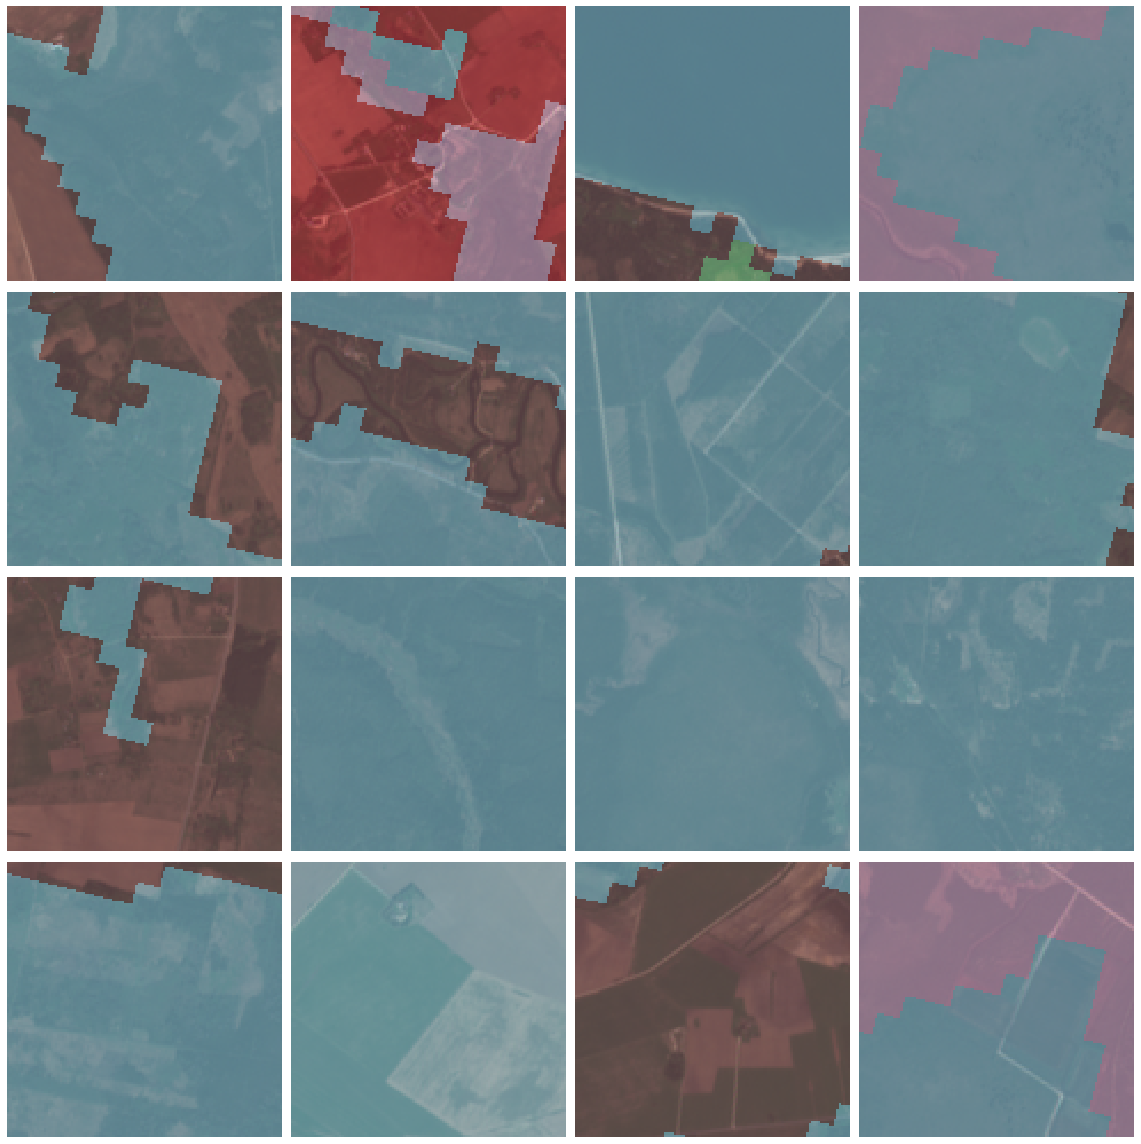

In [21]:
data.show_batch(ds_type=2)

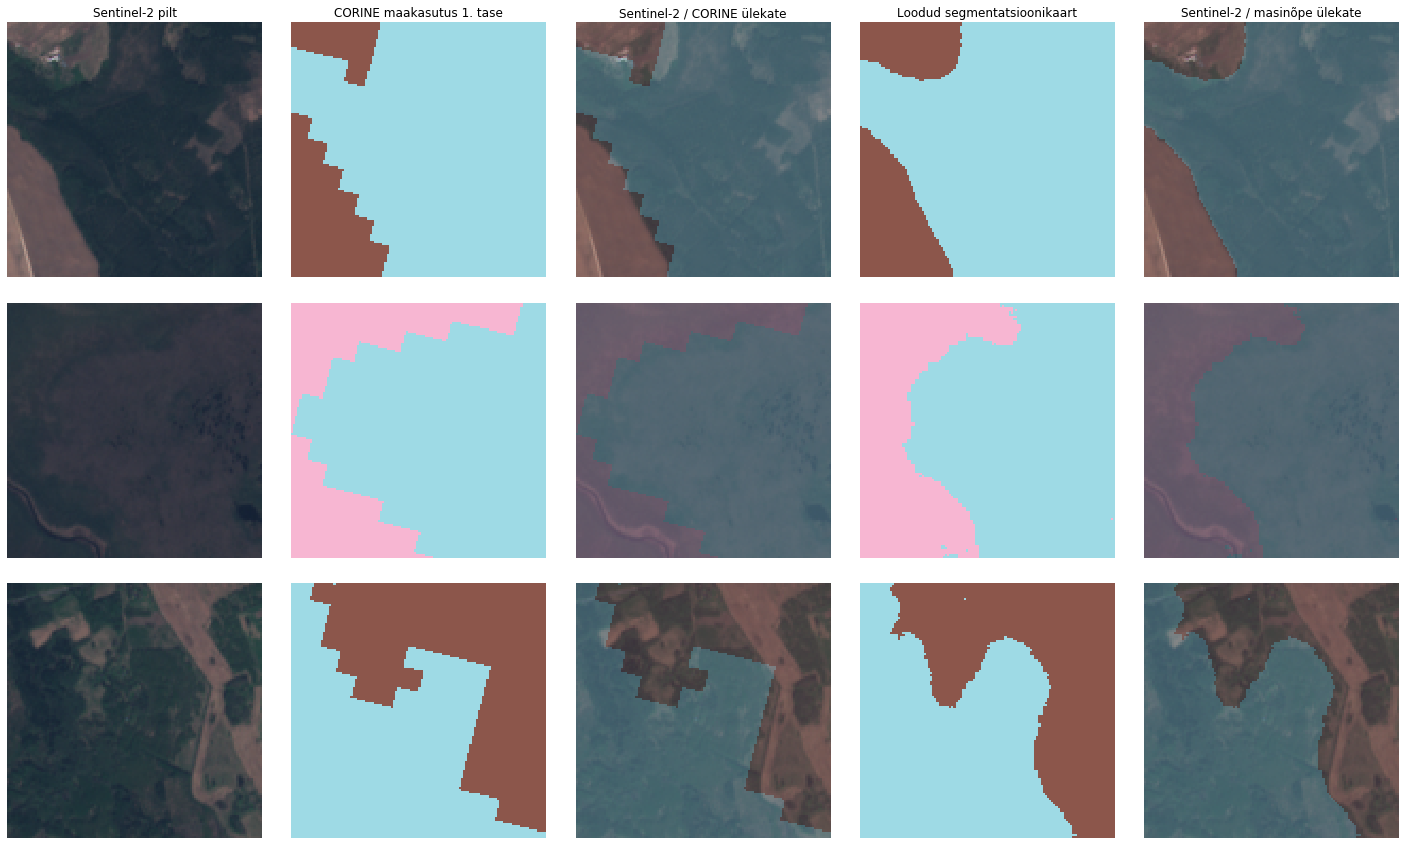

In [24]:
imgfn = fnames[0]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

cols = ['Sentinel-2 pilt','CORINE maakasutus 1. tase','Sentinel-2 / CORINE ülekate','Loodud segmentatsioonikaart','Sentinel-2 / masinõpe ülekate']
_,axes = plt.subplots(3,5, figsize=(25,15))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
img.show(ax=axes[0,0])
mask.show(ax=axes[0,1], alpha=1)
img.show(ax=axes[0,2], y=mask, alpha=0.3)
prediction.show(ax=axes[0,3], alpha=1)
img.show(ax=axes[0,4], y=prediction, alpha=0.3)

imgfn = fnames[3]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

img.show(ax=axes[1,0])
mask.show(ax=axes[1,1], alpha=1)
img.show(ax=axes[1,2], y=mask, alpha=0.3)
prediction.show(ax=axes[1,3], alpha=1)
img.show(ax=axes[1,4], y=prediction, alpha=0.3)

imgfn = fnames[4]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

img.show(ax=axes[2,0])
mask.show(ax=axes[2,1], alpha=1)
img.show(ax=axes[2,2], y=mask, alpha=0.3)
prediction.show(ax=axes[2,3], alpha=1)
img.show(ax=axes[2,4], y=prediction, alpha=0.3)

In [25]:
interp = SegmentationInterpretation.from_learner(learn)

In [26]:
top_losses, top_idxs = interp.top_losses(sizes=(120,120))

In [27]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
Metsad ja pool- looduslikud alad,0.858622
Vesi,0.825253
Põllumajanduslikud alad,0.769698
Tehisalad,0.416175
Märgalad,0.400048


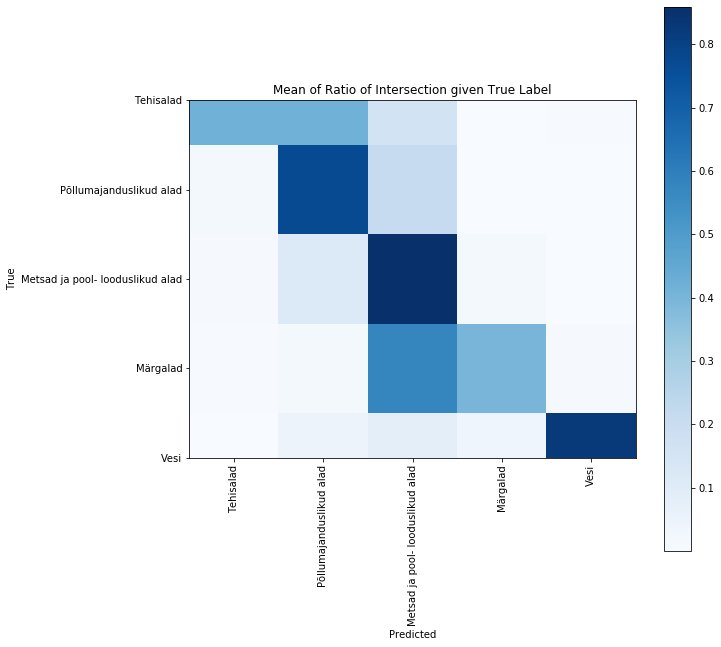

In [28]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

label,score
Metsad ja pool- looduslikud alad,0.0127094
Vesi,0
Tehisalad,NaN
Põllumajanduslikud alad,NaN
Märgalad,NaN


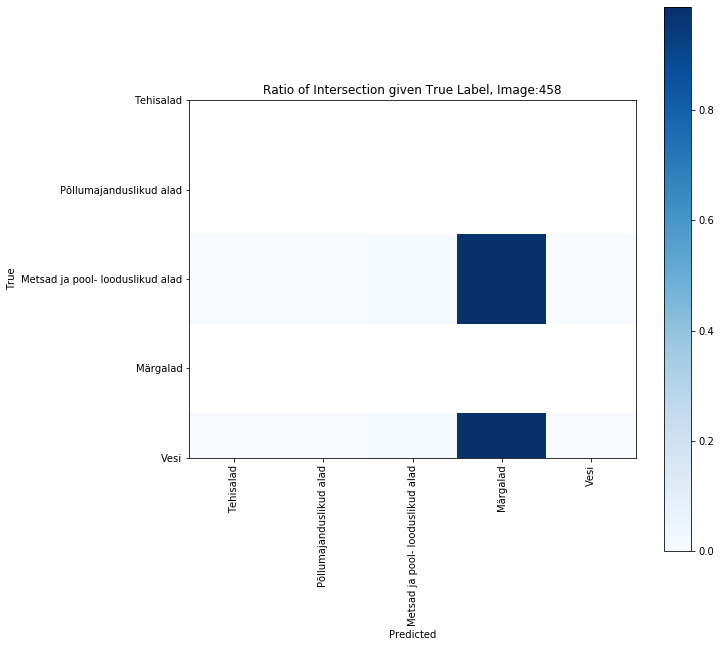

In [52]:
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

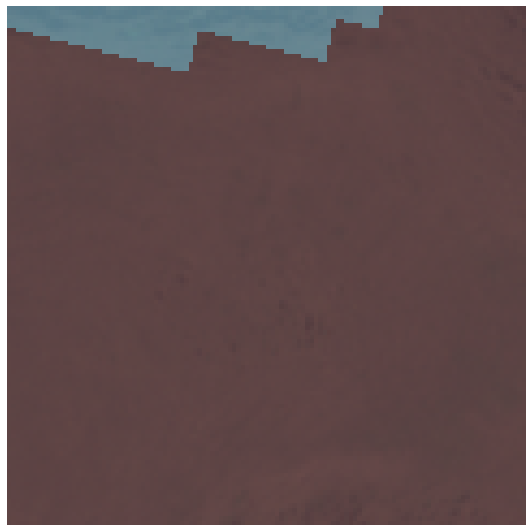

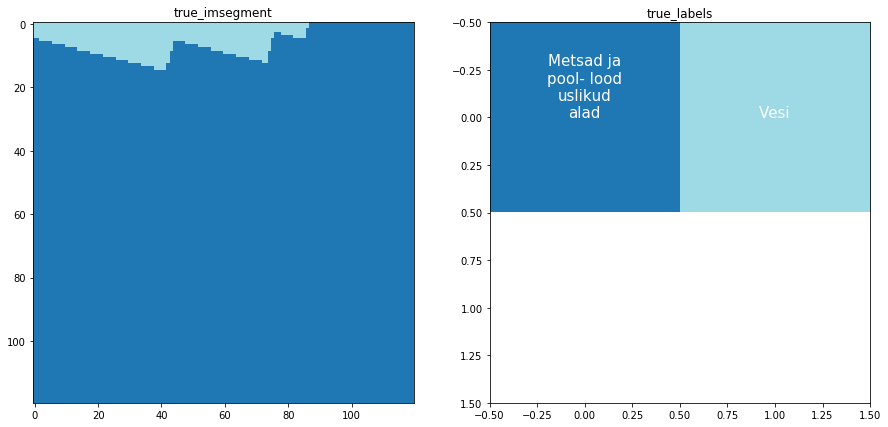

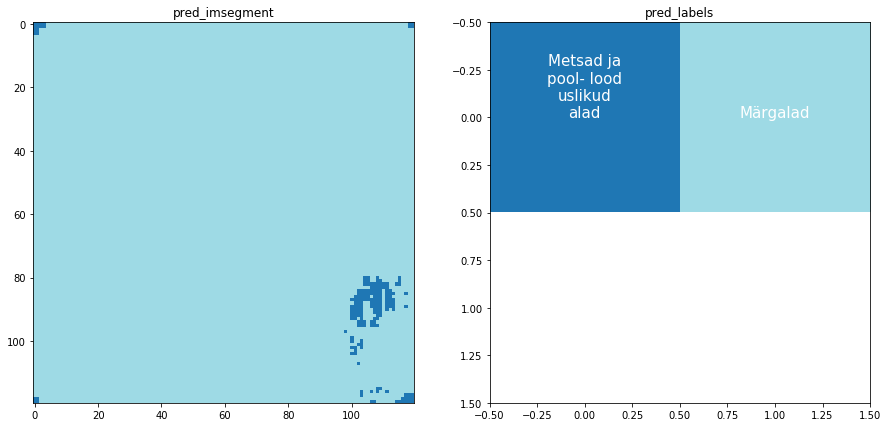

In [53]:
interp.show_xyz(i, sz=15)